# Hypertension Classification - Data Preparation

**Project**: PPG-based Hypertension Classification

**Objective**: Prepare and extract features from the Kaggle Blood Pressure Dataset for hypertension classification.

## Dataset Information
- **Source**: [Kaggle Blood Pressure Dataset](https://www.kaggle.com/datasets/mkachuee/BloodPressureDataset)
- **Signals**: PPG, ABP, ECG @ 125Hz
- **Format**: MATLAB .mat files

## Pipeline
1. Load data from .mat files
2. Extract BP labels from ABP signal
3. Data cleaning and quality checks
4. Signal preprocessing
5. Feature extraction
6. Save processed features

## 1. Setup and Imports

In [ ]:
# Install required packages (run once)
# !pip install scipy numpy pandas matplotlib seaborn scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import loadmat
from scipy.stats import kurtosis, skew
import warnings
from pathlib import Path
from typing import Dict, List, Tuple

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration

In [2]:
# Paths
DATA_DIR = Path(r'e:\study\iiit\new project\new new\data')
OUTPUT_DIR = Path(r'e:\study\iiit\new project\new new\processed_data')
OUTPUT_DIR.mkdir(exist_ok=True)

# Signal parameters
SAMPLING_RATE = 125  # Hz
SEGMENT_LENGTH = 10  # seconds
SEGMENT_SAMPLES = SAMPLING_RATE * SEGMENT_LENGTH

# BP classification thresholds (mmHg)
BP_THRESHOLDS = {
    'normotensive': {'sbp': (0, 120), 'dbp': (0, 80)},
    'prehypertensive': {'sbp': (120, 140), 'dbp': (80, 90)},
    'hypertensive': {'sbp': (140, 300), 'dbp': (90, 200)}
}

# Signal indices in dataset
PPG_INDEX = 0
ABP_INDEX = 1
ECG_INDEX = 2

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Sampling rate: {SAMPLING_RATE} Hz")
print(f"Segment length: {SEGMENT_LENGTH} seconds ({SEGMENT_SAMPLES} samples)")

Data directory: e:\study\iiit\new project\new new\data
Output directory: e:\study\iiit\new project\new new\processed_data
Sampling rate: 125 Hz
Segment length: 10 seconds (1250 samples)


## 3. Data Loading Functions

In [3]:
def load_mat_file(file_path: Path) -> List[np.ndarray]:
    """
    Load MATLAB file containing PPG, ABP, and ECG signals.
    
    Args:
        file_path: Path to .mat file
        
    Returns:
        List of record arrays, each containing [PPG, ABP, ECG] signals
    """
    try:
        mat_data = loadmat(str(file_path))
        
        # Find the main data variable (usually named 'p' or 'data')
        data_keys = [k for k in mat_data.keys() if not k.startswith('__')]
        
        if not data_keys:
            raise ValueError(f"No data found in {file_path}")
            
        main_key = data_keys[0]
        records = mat_data[main_key]
        
        # Extract records
        record_list = []
        if isinstance(records, np.ndarray):
            for record in records.flat:
                if isinstance(record, np.ndarray) and record.size > 0:
                    record_list.append(record)
        
        return record_list
    
    except Exception as e:
        raise RuntimeError(f"Error loading {file_path}: {str(e)}")


def extract_signals(record: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Extract PPG, ABP, and ECG signals from a record.
    
    Args:
        record: Array with shape (3, n_samples) or (n_samples, 3)
        
    Returns:
        Dictionary with 'ppg', 'abp', 'ecg' signals
    """
    # Ensure record has correct shape
    if record.shape[0] == 3:
        signals_dict = {
            'ppg': record[PPG_INDEX, :].flatten(),
            'abp': record[ABP_INDEX, :].flatten(),
            'ecg': record[ECG_INDEX, :].flatten()
        }
    elif record.shape[1] == 3:
        signals_dict = {
            'ppg': record[:, PPG_INDEX].flatten(),
            'abp': record[:, ABP_INDEX].flatten(),
            'ecg': record[:, ECG_INDEX].flatten()
        }
    else:
        raise ValueError(f"Invalid record shape: {record.shape}")
    
    return signals_dict


print("✓ Data loading functions defined")

✓ Data loading functions defined


## 4. Label Extraction from ABP Signal

In [4]:
def extract_bp_from_abp(abp_signal: np.ndarray, fs: int = SAMPLING_RATE) -> Tuple[float, float]:
    """
    Extract systolic and diastolic blood pressure from ABP signal.
    
    Args:
        abp_signal: Arterial blood pressure signal
        fs: Sampling frequency
        
    Returns:
        Tuple of (SBP, DBP) in mmHg
    """
    # Remove NaN and inf values
    abp_clean = abp_signal[np.isfinite(abp_signal)]
    
    if len(abp_clean) < fs:  # Need at least 1 second of data
        return np.nan, np.nan
    
    # Find peaks (systolic) and troughs (diastolic)
    # Peaks should be at least 0.5 seconds apart (120 bpm max)
    min_distance = int(0.5 * fs)
    
    try:
        peaks, _ = signal.find_peaks(abp_clean, distance=min_distance)
        troughs, _ = signal.find_peaks(-abp_clean, distance=min_distance)
        
        if len(peaks) < 2 or len(troughs) < 2:
            return np.nan, np.nan
        
        # Calculate median SBP and DBP
        sbp = np.median(abp_clean[peaks])
        dbp = np.median(abp_clean[troughs])
        
        # Sanity checks
        if sbp < 60 or sbp > 250 or dbp < 30 or dbp > 150 or sbp <= dbp:
            return np.nan, np.nan
        
        return sbp, dbp
    
    except Exception:
        return np.nan, np.nan


def classify_bp(sbp: float, dbp: float) -> str:
    """
    Classify blood pressure into normotensive, prehypertensive, or hypertensive.
    
    Args:
        sbp: Systolic blood pressure
        dbp: Diastolic blood pressure
        
    Returns:
        Class label: 'normotensive', 'prehypertensive', or 'hypertensive'
    """
    if np.isnan(sbp) or np.isnan(dbp):
        return 'invalid'
    
    # Hypertensive
    if sbp >= 140 or dbp >= 90:
        return 'hypertensive'
    
    # Prehypertensive
    if (120 <= sbp < 140) or (80 <= dbp < 90):
        return 'prehypertensive'
    
    # Normotensive
    if sbp < 120 and dbp < 80:
        return 'normotensive'
    
    return 'invalid'


print("✓ BP extraction and classification functions defined")

✓ BP extraction and classification functions defined


## 5. Data Cleaning Functions

In [5]:
def check_signal_quality(ppg_signal: np.ndarray) -> Dict[str, float]:
    """
    Check quality metrics for PPG signal.
    
    Args:
        ppg_signal: PPG signal array
        
    Returns:
        Dictionary with quality metrics
    """
    metrics = {}
    
    # Remove NaN/inf
    clean_signal = ppg_signal[np.isfinite(ppg_signal)]
    
    if len(clean_signal) == 0:
        return {'valid': False, 'reason': 'all_nan'}
    
    # Check for flat-line (zero variance)
    if np.var(clean_signal) < 1e-6:
        return {'valid': False, 'reason': 'flatline'}
    
    # Check for extreme outliers (>3 std)
    mean_val = np.mean(clean_signal)
    std_val = np.std(clean_signal)
    outlier_ratio = np.sum(np.abs(clean_signal - mean_val) > 3 * std_val) / len(clean_signal)
    
    if outlier_ratio > 0.1:  # More than 10% outliers
        return {'valid': False, 'reason': 'too_many_outliers'}
    
    # Calculate SNR (simplified)
    signal_power = np.var(clean_signal)
    noise_estimate = np.var(np.diff(clean_signal))  # High-frequency noise
    snr_db = 10 * np.log10(signal_power / (noise_estimate + 1e-10))
    
    metrics['valid'] = True
    metrics['snr_db'] = snr_db
    metrics['outlier_ratio'] = outlier_ratio
    metrics['missing_ratio'] = 1 - (len(clean_signal) / len(ppg_signal))
    
    return metrics


def clean_signal(ppg_signal: np.ndarray) -> np.ndarray:
    """
    Clean PPG signal by handling NaN/inf and outliers.
    
    Args:
        ppg_signal: Raw PPG signal
        
    Returns:
        Cleaned PPG signal
    """
    # Replace NaN/inf with interpolation
    signal_clean = ppg_signal.copy()
    
    # Find valid indices
    valid_idx = np.isfinite(signal_clean)
    
    if np.sum(valid_idx) < len(signal_clean) * 0.8:  # Less than 80% valid
        raise ValueError("Too many invalid values")
    
    # Interpolate invalid values
    if not np.all(valid_idx):
        x = np.arange(len(signal_clean))
        signal_clean[~valid_idx] = np.interp(x[~valid_idx], x[valid_idx], signal_clean[valid_idx])
    
    # Remove extreme outliers (clip to 3 std)
    mean_val = np.mean(signal_clean)
    std_val = np.std(signal_clean)
    signal_clean = np.clip(signal_clean, mean_val - 3*std_val, mean_val + 3*std_val)
    
    return signal_clean


print("✓ Data cleaning functions defined")

✓ Data cleaning functions defined


## 6. Signal Preprocessing Functions

In [6]:
def bandpass_filter(ppg_signal: np.ndarray, fs: int = SAMPLING_RATE, 
                   lowcut: float = 0.5, highcut: float = 8.0, order: int = 4) -> np.ndarray:
    """
    Apply bandpass filter to PPG signal (0.5-8 Hz for PPG).
    
    Args:
        ppg_signal: Input PPG signal
        fs: Sampling frequency
        lowcut: Low cutoff frequency
        highcut: High cutoff frequency
        order: Filter order
        
    Returns:
        Filtered PPG signal
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    sos = signal.butter(order, [low, high], btype='band', output='sos')
    filtered = signal.sosfiltfilt(sos, ppg_signal)
    
    return filtered


def normalize_signal(ppg_signal: np.ndarray) -> np.ndarray:
    """
    Z-score normalization (zero mean, unit variance).
    
    Args:
        ppg_signal: Input PPG signal
        
    Returns:
        Normalized PPG signal
    """
    mean_val = np.mean(ppg_signal)
    std_val = np.std(ppg_signal)
    
    if std_val < 1e-10:
        raise ValueError("Signal has zero variance")
    
    normalized = (ppg_signal - mean_val) / std_val
    return normalized


def preprocess_ppg(ppg_signal: np.ndarray) -> np.ndarray:
    """
    Complete preprocessing pipeline: clean -> filter -> normalize.
    
    Args:
        ppg_signal: Raw PPG signal
        
    Returns:
        Preprocessed PPG signal
    """
    # Clean
    cleaned = clean_signal(ppg_signal)
    
    # Filter
    filtered = bandpass_filter(cleaned)
    
    # Normalize
    normalized = normalize_signal(filtered)
    
    return normalized


print("✓ Preprocessing functions defined")

✓ Preprocessing functions defined


## 7. Feature Extraction Functions

In [7]:
def detect_ppg_peaks(ppg_signal: np.ndarray, fs: int = SAMPLING_RATE) -> np.ndarray:
    """
    Detect systolic peaks in PPG signal.
    
    Args:
        ppg_signal: Preprocessed PPG signal
        fs: Sampling frequency
        
    Returns:
        Array of peak indices
    """
    # Minimum distance between peaks (0.4 seconds = 150 bpm max)
    min_distance = int(0.4 * fs)
    
    # Find peaks
    peaks, properties = signal.find_peaks(
        ppg_signal, 
        distance=min_distance,
        prominence=0.5  # Require significant prominence
    )
    
    return peaks


def extract_morphological_features(ppg_signal: np.ndarray, peaks: np.ndarray) -> Dict[str, float]:
    """
    Extract morphological features from PPG signal.
    
    Features:
    - Systolic peak height (mean, std)
    - Pulse width
    - Peak-to-peak interval
    
    Args:
        ppg_signal: Preprocessed PPG signal
        peaks: Peak indices
        
    Returns:
        Dictionary of morphological features
    """
    features = {}
    
    if len(peaks) < 2:
        # Return NaN if not enough peaks
        return {f'morph_{k}': np.nan for k in ['peak_height_mean', 'peak_height_std', 
                                                  'pulse_width_mean', 'pulse_interval_mean']}
    
    # Peak heights
    peak_heights = ppg_signal[peaks]
    features['morph_peak_height_mean'] = np.mean(peak_heights)
    features['morph_peak_height_std'] = np.std(peak_heights)
    
    # Peak-to-peak intervals
    peak_intervals = np.diff(peaks) / SAMPLING_RATE  # Convert to seconds
    features['morph_pulse_interval_mean'] = np.mean(peak_intervals)
    features['morph_pulse_interval_std'] = np.std(peak_intervals)
    
    # Pulse width (approximate as half-height width)
    pulse_widths = []
    for i in range(len(peaks) - 1):
        start_idx = peaks[i]
        end_idx = peaks[i + 1]
        pulse_segment = ppg_signal[start_idx:end_idx]
        
        if len(pulse_segment) > 10:
            half_height = peak_heights[i] / 2
            above_half = pulse_segment > half_height
            pulse_width = np.sum(above_half) / SAMPLING_RATE
            pulse_widths.append(pulse_width)
    
    features['morph_pulse_width_mean'] = np.mean(pulse_widths) if pulse_widths else np.nan
    
    return features


def extract_physiological_features(peaks: np.ndarray, fs: int = SAMPLING_RATE) -> Dict[str, float]:
    """
    Extract physiological features (HR, HRV) from peak intervals.
    
    Features:
    - Heart Rate (HR)
    - RMSSD (Root Mean Square of Successive Differences)
    - SDNN (Standard Deviation of NN intervals)
    - pNN50 (Percentage of successive intervals > 50ms)
    
    Args:
        peaks: Peak indices
        fs: Sampling frequency
        
    Returns:
        Dictionary of physiological features
    """
    features = {}
    
    if len(peaks) < 3:
        return {f'physio_{k}': np.nan for k in ['hr_mean', 'hr_std', 'rmssd', 'sdnn', 'pnn50']}
    
    # Peak-to-peak intervals in milliseconds
    pp_intervals = np.diff(peaks) / fs * 1000  # Convert to ms
    
    # Heart Rate
    hr = 60000 / pp_intervals  # BPM
    features['physio_hr_mean'] = np.mean(hr)
    features['physio_hr_std'] = np.std(hr)
    
    # HRV metrics
    # RMSSD
    successive_diffs = np.diff(pp_intervals)
    features['physio_rmssd'] = np.sqrt(np.mean(successive_diffs ** 2))
    
    # SDNN
    features['physio_sdnn'] = np.std(pp_intervals)
    
    # pNN50
    nn50 = np.sum(np.abs(successive_diffs) > 50)
    features['physio_pnn50'] = (nn50 / len(successive_diffs)) * 100
    
    return features


def extract_statistical_features(ppg_signal: np.ndarray) -> Dict[str, float]:
    """
    Extract statistical features from PPG signal.
    
    Features:
    - Mean, Standard Deviation
    - Kurtosis, Skewness
    - Min, Max, Range
    
    Args:
        ppg_signal: Preprocessed PPG signal
        
    Returns:
        Dictionary of statistical features
    """
    features = {
        'stat_mean': np.mean(ppg_signal),
        'stat_std': np.std(ppg_signal),
        'stat_kurtosis': kurtosis(ppg_signal),
        'stat_skewness': skew(ppg_signal),
        'stat_min': np.min(ppg_signal),
        'stat_max': np.max(ppg_signal),
        'stat_range': np.ptp(ppg_signal),
        'stat_median': np.median(ppg_signal)
    }
    
    return features


def extract_all_features(ppg_signal: np.ndarray) -> Dict[str, float]:
    """
    Extract all features from PPG signal.
    
    Args:
        ppg_signal: Preprocessed PPG signal
        
    Returns:
        Dictionary with all features
    """
    all_features = {}
    
    # Detect peaks
    peaks = detect_ppg_peaks(ppg_signal)
    
    # Extract features
    all_features.update(extract_morphological_features(ppg_signal, peaks))
    all_features.update(extract_physiological_features(peaks))
    all_features.update(extract_statistical_features(ppg_signal))
    
    return all_features


print("✓ Feature extraction functions defined")

✓ Feature extraction functions defined


## 8. Load and Process Dataset

In [8]:
# Find all .mat files in data directory
mat_files = sorted(DATA_DIR.glob('*.mat'))

print(f"Found {len(mat_files)} .mat files")
print("\nFiles:")
for f in mat_files[:5]:  # Show first 5
    print(f"  - {f.name}")
if len(mat_files) > 5:
    print(f"  ... and {len(mat_files) - 5} more")

Found 1 .mat files

Files:
  - part_1.mat


In [9]:
# Process all records
all_features_list = []
processing_stats = {
    'total_records': 0,
    'processed': 0,
    'failed_quality': 0,
    'failed_bp': 0,
    'failed_processing': 0
}

print("Processing records...\n")

for file_idx, mat_file in enumerate(mat_files):
    print(f"Processing {mat_file.name} ({file_idx + 1}/{len(mat_files)})...")
    
    try:
        # Load file
        records = load_mat_file(mat_file)
        print(f"  Loaded {len(records)} records")
        
        # Process each record
        for record_idx, record in enumerate(records):
            processing_stats['total_records'] += 1
            
            try:
                # Extract signals
                signals = extract_signals(record)
                ppg = signals['ppg']
                abp = signals['abp']
                
                # Check minimum length
                if len(ppg) < SEGMENT_SAMPLES:
                    processing_stats['failed_quality'] += 1
                    continue
                
                # Extract BP label
                sbp, dbp = extract_bp_from_abp(abp)
                bp_class = classify_bp(sbp, dbp)
                
                if bp_class == 'invalid':
                    processing_stats['failed_bp'] += 1
                    continue
                
                # Process PPG in segments
                num_segments = len(ppg) // SEGMENT_SAMPLES
                
                for seg_idx in range(num_segments):
                    start = seg_idx * SEGMENT_SAMPLES
                    end = start + SEGMENT_SAMPLES
                    ppg_segment = ppg[start:end]
                    
                    # Quality check
                    quality = check_signal_quality(ppg_segment)
                    if not quality.get('valid', False):
                        processing_stats['failed_quality'] += 1
                        continue
                    
                    # Preprocess
                    ppg_preprocessed = preprocess_ppg(ppg_segment)
                    
                    # Extract features
                    features = extract_all_features(ppg_preprocessed)
                    
                    # Add metadata
                    features['file_name'] = mat_file.stem
                    features['record_idx'] = record_idx
                    features['segment_idx'] = seg_idx
                    features['sbp'] = sbp
                    features['dbp'] = dbp
                    features['bp_class'] = bp_class
                    
                    all_features_list.append(features)
                    processing_stats['processed'] += 1
            
            except Exception as e:
                processing_stats['failed_processing'] += 1
                continue
    
    except Exception as e:
        print(f"  Error loading file: {e}")
        continue
    
    # Progress update every 5 files
    if (file_idx + 1) % 5 == 0:
        print(f"\n  Progress: {processing_stats['processed']} segments processed\n")

print("\n" + "="*50)
print("Processing Complete!")
print("="*50)
print(f"Total records examined: {processing_stats['total_records']}")
print(f"Successfully processed: {processing_stats['processed']}")
print(f"Failed quality check: {processing_stats['failed_quality']}")
print(f"Failed BP extraction: {processing_stats['failed_bp']}")
print(f"Failed processing: {processing_stats['failed_processing']}")

Processing records...

Processing part_1.mat (1/1)...
  Loaded 1000 records

Processing Complete!
Total records examined: 1000
Successfully processed: 25201
Failed quality check: 72
Failed BP extraction: 1
Failed processing: 0


## 9. Create Features DataFrame

In [10]:
# Create DataFrame
df_features = pd.DataFrame(all_features_list)

print(f"Created DataFrame with {len(df_features)} samples")
print(f"Number of features: {len(df_features.columns) - 6}")  # Exclude metadata columns

# Display class distribution
print("\nClass Distribution:")
class_counts = df_features['bp_class'].value_counts()
print(class_counts)
print(f"\nClass percentages:")
print(class_counts / len(df_features) * 100)

# Display first few rows
print("\nFirst few samples:")
df_features.head()

Created DataFrame with 25201 samples
Number of features: 18

Class Distribution:
bp_class
hypertensive       13724
prehypertensive     6609
normotensive        4868
Name: count, dtype: int64

Class percentages:
bp_class
hypertensive       54.458156
prehypertensive    26.225150
normotensive       19.316694
Name: count, dtype: float64

First few samples:


,morph_peak_height_mean,morph_peak_height_std,morph_pulse_interval_mean,morph_pulse_interval_std,morph_pulse_width_mean,physio_hr_mean,physio_hr_std,physio_rmssd,physio_sdnn,physio_pnn50,...,stat_min,stat_max,stat_range,stat_median,file_name,record_idx,segment_idx,sbp,dbp,bp_class
0,1.815248,0.086994,0.487158,0.007293,0.123368,123.190711,1.827640,5.962848,7.292846,0.0,...,-1.364970,1.962148,3.327119,-0.361339,part_1,0,0,133.490937,72.973092,prehypertensive
1,1.732987,0.204921,0.486800,0.004578,0.120000,123.264807,1.159507,7.567242,4.578209,0.0,...,-1.657545,2.446756,4.104300,-0.311439,part_1,0,1,133.490937,72.973092,prehypertensive
2,1.801959,0.118465,0.484632,0.006523,0.124211,123.827903,1.673089,8.219219,6.522919,0.0,...,-1.623220,2.194896,3.818116,-0.337583,part_1,0,2,133.490937,72.973092,prehypertensive
3,1.716197,0.253897,0.490105,0.006274,0.126737,122.442873,1.577602,9.043107,6.273543,0.0,...,-1.855639,2.258061,4.113700,-0.266565,part_1,0,3,133.490937,72.973092,prehypertensive
4,1.718656,0.442542,0.488842,0.008952,0.125474,122.780367,2.258549,10.832051,8.951702,0.0,...,-2.349261,2.780818,5.130079,-0.229093,part_1,0,4,133.490937,72.973092,prehypertensive


## 10. Handle Missing Values

In [11]:
# Check for missing values
print("Missing values per column:")
missing_counts = df_features.isnull().sum()
missing_cols = missing_counts[missing_counts > 0]

if len(missing_cols) > 0:
    print(missing_cols)
    print(f"\nTotal missing: {missing_counts.sum()}")
    
    # Drop rows with any NaN in feature columns
    feature_cols = [col for col in df_features.columns if col not in 
                   ['file_name', 'record_idx', 'segment_idx', 'sbp', 'dbp', 'bp_class']]
    
    df_features_clean = df_features.dropna(subset=feature_cols)
    
    print(f"\nDropped {len(df_features) - len(df_features_clean)} rows with missing values")
    print(f"Remaining samples: {len(df_features_clean)}")
else:
    print("No missing values found!")
    df_features_clean = df_features.copy()

# Update class distribution after cleaning
print("\nClass distribution after cleaning:")
print(df_features_clean['bp_class'].value_counts())

Missing values per column:
No missing values found!

Class distribution after cleaning:
bp_class
hypertensive       13724
prehypertensive     6609
normotensive        4868
Name: count, dtype: int64


## 11. Visualize Data Distribution

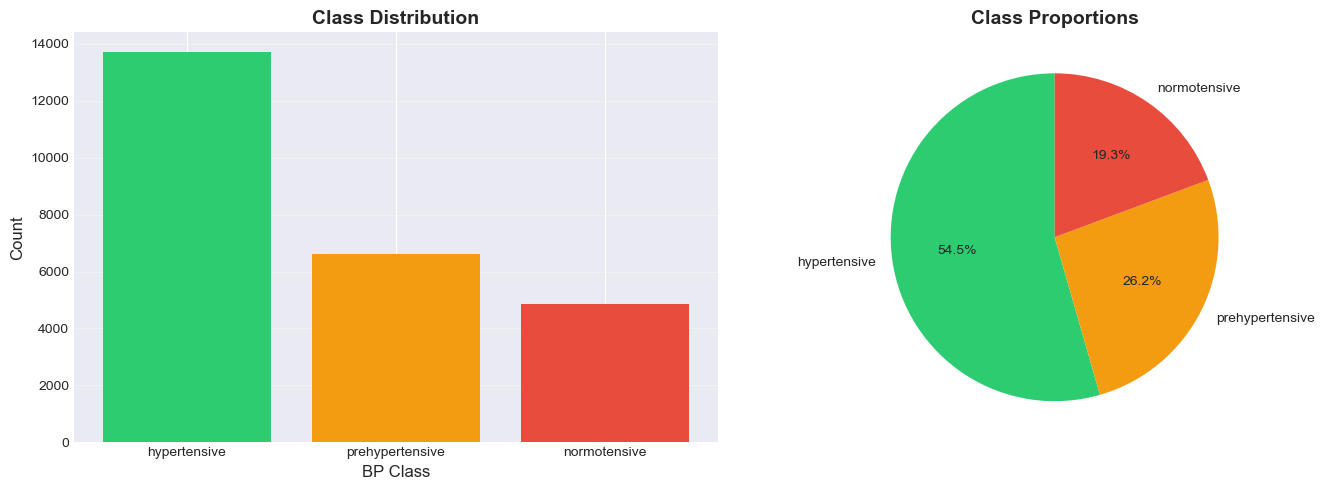

✓ Saved class distribution plot


In [12]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts = df_features_clean['bp_class'].value_counts()
axes[0].bar(class_counts.index, class_counts.values, color=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0].set_xlabel('BP Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
           colors=colors, startangle=90)
axes[1].set_title('Class Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved class distribution plot")

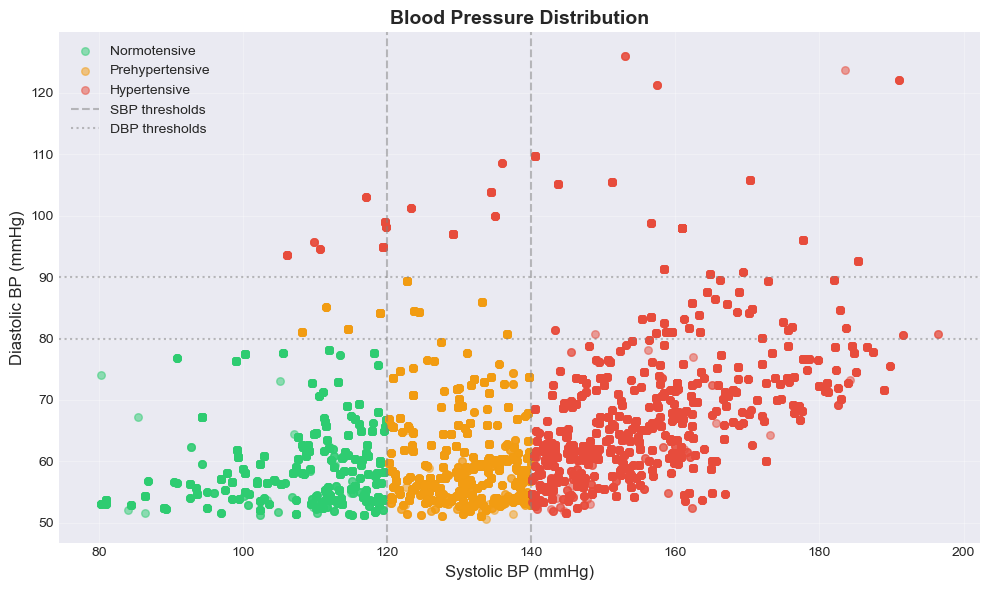

✓ Saved BP scatter plot


In [13]:
# SBP vs DBP scatter plot
plt.figure(figsize=(10, 6))

for bp_class, color in zip(['normotensive', 'prehypertensive', 'hypertensive'], 
                           ['#2ecc71', '#f39c12', '#e74c3c']):
    mask = df_features_clean['bp_class'] == bp_class
    plt.scatter(df_features_clean.loc[mask, 'sbp'], 
               df_features_clean.loc[mask, 'dbp'],
               alpha=0.5, label=bp_class.capitalize(), color=color, s=30)

# Add threshold lines
plt.axvline(x=120, color='gray', linestyle='--', alpha=0.5, label='SBP thresholds')
plt.axvline(x=140, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=80, color='gray', linestyle=':', alpha=0.5, label='DBP thresholds')
plt.axhline(y=90, color='gray', linestyle=':', alpha=0.5)

plt.xlabel('Systolic BP (mmHg)', fontsize=12)
plt.ylabel('Diastolic BP (mmHg)', fontsize=12)
plt.title('Blood Pressure Distribution', fontsize=14, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'bp_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved BP scatter plot")

## 12. Save Processed Features

In [14]:
# Save to CSV
output_file = OUTPUT_DIR / 'ppg_features.csv'
df_features_clean.to_csv(output_file, index=False)

print(f"✓ Saved processed features to: {output_file}")
print(f"  Total samples: {len(df_features_clean)}")
print(f"  Total features: {len(df_features_clean.columns) - 6}")
print(f"  File size: {output_file.stat().st_size / 1024:.2f} KB")

✓ Saved processed features to: e:\study\iiit\new project\new new\processed_data\ppg_features.csv
  Total samples: 25201
  Total features: 18
  File size: 9485.19 KB


## 13. Summary Statistics

In [15]:
# Feature columns
feature_cols = [col for col in df_features_clean.columns if col not in 
               ['file_name', 'record_idx', 'segment_idx', 'sbp', 'dbp', 'bp_class']]

# Summary statistics
print("Feature Summary Statistics:")
print("="*80)
summary = df_features_clean[feature_cols].describe().T
summary = summary[['mean', 'std', 'min', 'max']]
print(summary)

# Save summary
summary.to_csv(OUTPUT_DIR / 'feature_summary.csv')
print(f"\n✓ Saved feature summary to: {OUTPUT_DIR / 'feature_summary.csv'}")

Feature Summary Statistics:
                                   mean           std           min  \
morph_peak_height_mean     1.857447e+00  1.989679e-01  1.020178e+00   
morph_peak_height_std      2.424476e-01  1.260795e-01  2.651479e-02   
morph_pulse_interval_mean  7.700795e-01  1.287714e-01  4.418182e-01   
morph_pulse_interval_std   4.115704e-02  4.279149e-02  0.000000e+00   
morph_pulse_width_mean     1.780093e-01  3.208882e-02  8.842105e-02   
physio_hr_mean             8.089267e+01  1.508756e+01  5.215176e+01   
physio_hr_std              4.678407e+00  5.061870e+00  0.000000e+00   
physio_rmssd               6.121717e+01  6.558096e+01  0.000000e+00   
physio_sdnn                4.115704e+01  4.279149e+01  0.000000e+00   
physio_pnn50               1.660286e+01  2.173710e+01  0.000000e+00   
stat_mean                 -2.707815e-19  2.245886e-17 -7.673862e-17   
stat_std                   1.000000e+00  8.243727e-17  1.000000e+00   
stat_kurtosis             -7.920665e-01  3.466354

## 14. Feature Correlation Analysis

Top 10 features correlated with SBP:
physio_hr_mean               0.292136
morph_pulse_interval_mean    0.273915
stat_median                  0.238537
stat_skewness                0.220543
stat_min                     0.185710
morph_peak_height_mean       0.159926
morph_pulse_width_mean       0.150577
stat_range                   0.095905
stat_kurtosis                0.057264
physio_sdnn                  0.057209
dtype: float64

Top 10 features correlated with DBP:
morph_pulse_interval_mean    0.168673
physio_hr_mean               0.166107
stat_skewness                0.143087
stat_min                     0.135579
morph_peak_height_mean       0.133195
physio_pnn50                 0.121817
stat_kurtosis                0.111630
physio_rmssd                 0.098442
physio_sdnn                  0.085137
morph_pulse_interval_std     0.085137
dtype: float64


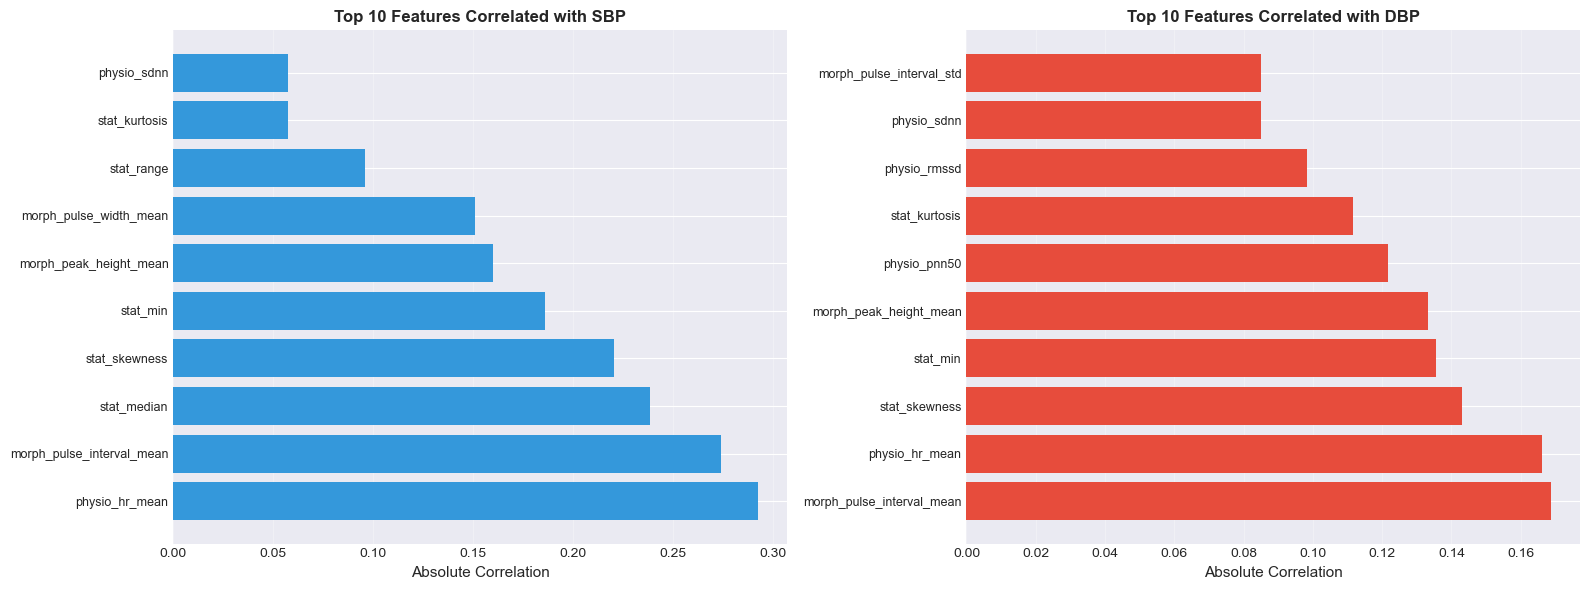


✓ Saved feature correlation plot


In [16]:
# Calculate correlation with BP
correlations_sbp = df_features_clean[feature_cols].corrwith(df_features_clean['sbp']).abs().sort_values(ascending=False)
correlations_dbp = df_features_clean[feature_cols].corrwith(df_features_clean['dbp']).abs().sort_values(ascending=False)

print("Top 10 features correlated with SBP:")
print(correlations_sbp.head(10))

print("\nTop 10 features correlated with DBP:")
print(correlations_dbp.head(10))

# Plot correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SBP correlations
top_sbp = correlations_sbp.head(10)
axes[0].barh(range(len(top_sbp)), top_sbp.values, color='#3498db')
axes[0].set_yticks(range(len(top_sbp)))
axes[0].set_yticklabels(top_sbp.index, fontsize=9)
axes[0].set_xlabel('Absolute Correlation', fontsize=11)
axes[0].set_title('Top 10 Features Correlated with SBP', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# DBP correlations
top_dbp = correlations_dbp.head(10)
axes[1].barh(range(len(top_dbp)), top_dbp.values, color='#e74c3c')
axes[1].set_yticks(range(len(top_dbp)))
axes[1].set_yticklabels(top_dbp.index, fontsize=9)
axes[1].set_xlabel('Absolute Correlation', fontsize=11)
axes[1].set_title('Top 10 Features Correlated with DBP', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved feature correlation plot")

## 15. Final Report

In [17]:
print("\n" + "="*80)
print("DATA PREPARATION COMPLETE")
print("="*80)
print(f"\n✓ Processed {len(df_features_clean)} samples")
print(f"✓ Extracted {len(feature_cols)} features per sample")
print(f"\n✓ Class Distribution:")
for bp_class, count in df_features_clean['bp_class'].value_counts().items():
    percentage = (count / len(df_features_clean)) * 100
    print(f"   - {bp_class.capitalize()}: {count} ({percentage:.1f}%)")

print(f"\n✓ Output files:")
print(f"   - Features: {OUTPUT_DIR / 'ppg_features.csv'}")
print(f"   - Summary: {OUTPUT_DIR / 'feature_summary.csv'}")
print(f"   - Plots: {OUTPUT_DIR}/*.png")

print(f"\n✓ Ready for classification notebook!")
print("="*80)


DATA PREPARATION COMPLETE

✓ Processed 25201 samples
✓ Extracted 18 features per sample

✓ Class Distribution:
   - Hypertensive: 13724 (54.5%)
   - Prehypertensive: 6609 (26.2%)
   - Normotensive: 4868 (19.3%)

✓ Output files:
   - Features: e:\study\iiit\new project\new new\processed_data\ppg_features.csv
   - Summary: e:\study\iiit\new project\new new\processed_data\feature_summary.csv
   - Plots: e:\study\iiit\new project\new new\processed_data/*.png

✓ Ready for classification notebook!
